# Instalação e importação das bibliotecas

Para iniciar corretamente o projeto vamos instalar as dependências e importa-las no kernel

In [1]:
!pip install opencv-python-headless numpy tensorflow matplotlib

print('Instalação concluída!')

Instalação concluida


###### Após a instalação ser concluída, faremos as importações

In [39]:
import os
import random
import shutil

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, UpSampling2D, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print('Importação concluída!')

Importação concluída!


**Atenção:** O aviso acima apenas informa que não foram encontrados drivers cuda e por conta disso será usada a CPU da máquina ao invés da GPU

Durante algumas execuções relacionadas diretamente com o Tensorflow, como declaração, compilação ou treinamento do modelo poderão aparecer mais avisos sobre o mesmo motivo

###### Vamos definir algumas variaveis que serão usadas em todo o escopo do projeto, como tamanho das imagens, nomenclatura das pastas e classes

In [10]:
original_dataset_dir = './dataset'
normalized_dataset_dir = './normalized-dataset'
columns_dataset_dir = './columns'
balanced_dataset_generalist_model_dir = './balanced-dataset-generalist-model'
balanced_dataset_kyphosis_model_dir = './balanced-dataset-kyphosis-model'
balanced_dataset_lordosis_model_dir = './balanced-dataset-lordosis-model'
image_height = 256
image_width = 256
generalist_classes = ['healthy', 'kyphosis', 'kyphosis_and_lordosis', 'lordosis']
kyphosis_classes = ['healthy', 'kyphosis']
lordosis_classes = ['healthy', 'lordosis']
batch_size = 6

print('Definição concluída!')

Definição concluida


# Coleta e processamento de dados

Vamos inicializar o projeto normalizando as imagens, para facilitar a identificação das vertebras nas imagens de raio-x

A função definida como `normalize_image` será reaproveitada para usarmos também no processo de inferencia do modelo, iremos nessa função chamar as funções:
- `decrease_brightness` -> Para facilitar a identificação exclusivamente das colunas, vamos reduzir o btilho em 60%
- `increase_contrast` -> Para aumentar o contraste no fator 1.5
- `make_square` -> Como as redes CNNs usam imagens quadradas para efetuar seu treinamento e aferição, para evitar distorção nas imagens, vamos adicionar bordas pretas

In [4]:
def decrease_brightness(image, factor=0.4):
    image = image.astype(np.float32)
    image = image * (1 - factor)
    image = np.clip(image, 0, 255)
    return image.astype(np.uint8)

def increase_contrast(image, alpha=1.5):
    image = image.astype(np.float32)
    image = image * alpha
    image = np.clip(image, 0, 255)
    return image.astype(np.uint8)

def make_square(image):
    height, width = image.shape[:2]
    size = max(height, width)
    top = (size - height) // 2
    bottom = size - height - top
    left = (size - width) // 2
    right = size - width - left
    squared_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return squared_image

def normalize_image(image, brightness_factor=0.5, contrast_alpha=1.5):
    image = decrease_brightness(image, factor=brightness_factor)
    image = increase_contrast(image, alpha=contrast_alpha)
    squared_image = make_square(image)
    return squared_image

print('Definição da função normalize_image concluída!')

Definição da função normalize_image concluida


###### Após a definição da função, vamos normalizar as imagens do DataSet

In [ ]:
for root, dirs, files in os.walk(original_dataset_dir):
    for file in files:
        if file.lower().endswith('.jpg'):
            input_path = os.path.join(root, file)
            
            relative_path = os.path.relpath(root, original_dataset_dir)
            output_subdir = os.path.join(normalized_dataset_dir, relative_path)
            os.makedirs(output_subdir, exist_ok=True)
            
            output_path = os.path.join(output_subdir, file)

            image = cv2.imread(input_path)
            if image is None:
                print(f"Falha ao carregar a imagem: {input_path}")
                continue

            normalized_image = normalize_image(image)

            cv2.imwrite(output_path, normalized_image)

print(f'Normalização concluída e imagens salvas em {normalized_dataset_dir}!')

## Balanceamento do DataSet
Para evitar maior peso em um determinado tipo de dado, será feito um balanceamento do dataset.

Para isso, foi utilizado o método de reamostragem chamado de undersampling, no qual foi selecionado aleatoriamente os dados de uma classe e duplicado até que a quantidade de dados de cada classe se iguale.

Como cada modelo terá diferentes possibilidades, foi criado um dataset para cada modelo
- Para o modelo de Cifose as imagens dos casos com Cifose e Cifose com Lordose serão considerados apenas como Cifose, e os casos com Lordose e saudáveis serão considerados como saudáveis
- Para o modelo de Lordose as imagens dos casos com Lordose e Cifose com Lordose serão considerados apenas como Lordose, e os casos com Cifose e saudáveis serão considerados como saudáveis
- Para o modelo Generalista as imagens e seus casos originais foram preservados

###### Para seguir a definição acima, vamos criar o mapeamento usando objetos chave-valor

In [ ]:
kyphosis_mapping = {
    'kyphosis': 'kyphosis',
    'healthy': 'healthy',
    'kyphosis_and_lordosis': 'kyphosis',
    'lordosis': 'healthy'
}

lordosis_mapping = {
    'lordosis': 'lordosis',
    'healthy': 'healthy',
    'kyphosis_and_lordosis': 'lordosis',
    'kyphosis': 'healthy'
}

print('Mapping definido com sucesso!')

###### Então vamos criar uma função `balance_dataset` que vai fazer o balanceamento dos dataset, baseando-se nesse mapping já definido

In [ ]:
def balance_dataset(dataset_dir, classes, output_dir, class_mapping=None):
    os.makedirs(output_dir, exist_ok=True)

    image_counts = {}
    for cls in classes:
        if class_mapping and cls in class_mapping.values():
            source_classes = [k for k, v in class_mapping.items() if v == cls]
            total_images = 0
            for src_cls in source_classes:
                cls_path = os.path.join(dataset_dir, src_cls)
                if os.path.isdir(cls_path):
                    total_images += len([f for f in os.listdir(cls_path) 
                                         if os.path.isfile(os.path.join(cls_path, f))])
            image_counts[cls] = total_images
        else:
            cls_path = os.path.join(dataset_dir, cls)
            if os.path.isdir(cls_path):
                image_counts[cls] = len([f for f in os.listdir(cls_path) 
                                         if os.path.isfile(os.path.join(cls_path, f))])
            else:
                image_counts[cls] = 0 

    max_images = max(image_counts.values())
    
    for cls in classes:
        cls_output_path = os.path.join(output_dir, cls)
        os.makedirs(cls_output_path, exist_ok=True)

        if class_mapping and cls in class_mapping.values():
            source_classes = [k for k, v in class_mapping.items() if v == cls]
        else:
            source_classes = [cls]

        images = []
        for source_cls in source_classes:
            cls_source_path = os.path.join(dataset_dir, source_cls)
            if os.path.isdir(cls_source_path):
                images += [f for f in os.listdir(cls_source_path) 
                           if os.path.isfile(os.path.join(cls_source_path, f))]

        if not images:
            continue

        for index, image in enumerate(images):
            src_image_path = None
            for src_cls in source_classes:
                temp_path = os.path.join(dataset_dir, src_cls, image)
                if os.path.exists(temp_path):
                    src_image_path = temp_path
                    break
            
            if src_image_path:
                new_name = f"{cls}_{index + 1:03d}.jpg"
                shutil.copy(src_image_path, os.path.join(cls_output_path, new_name))

        current_count = len(images)
        while current_count < max_images:
            image_to_copy = random.choice(images)
            src_image_path = os.path.join(dataset_dir, source_classes[0], image_to_copy)
            if os.path.exists(src_image_path):
                new_name = f"{cls}_{current_count + 1:03d}.jpg"
                shutil.copy(src_image_path, os.path.join(cls_output_path, new_name))
                current_count += 1

print('Função de balanceamento definida com sucesso!')

###### Após isso, balancearemos o dataset normalizado

In [ ]:
balance_dataset(normalized_dataset_dir, generalist_classes, balanced_dataset_generalist_model_dir)
balance_dataset(normalized_dataset_dir, kyphosis_classes, balanced_dataset_kyphosis_model_dir, kyphosis_mapping)
balance_dataset(normalized_dataset_dir, lordosis_classes, balanced_dataset_lordosis_model_dir, lordosis_mapping)

print('Funções de balanceamento executada com sucesso!')

## Geração de variações das imagens

Próximo passo para iniciar o treinamento, será criar um gerador de variações das imagens

Para melhorar a amplitude do treinamento, foi utilizado o gerador de alterações nas imagens, que trás alterações em rotação, deslocamento, zoom, brilho e direção.
Vamos definir um datagen para o modelo Generalista e um para os modelos especialistas

In [5]:
generalist_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    brightness_range = [0.8, 1.5]
)

especialist_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.5]
)

especialist_val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.5],
    validation_split=0.2
)

print('DataGens criados com sucesso!')

DataGens criados com sucesso


# Criando DataFrame

DataFrame serve para indicar à quais classes a imagem pertence. É uma classificação feita atravez de vetores de binários, que funcionam como indicativo de pertencimento

In [49]:
def create_dataset_labels(base_dir):
    data = {
        'filename': [],
        'kyphosis': [],
        'lordosis': []
    }

    class_mapping = {
        'healthy': (0, 0),
        'kyphosis': (1, 0),
        'kyphosis_and_lordosis': (1, 1),
        'lordosis': (0, 1)
    }

    for class_folder, (kyphosis_label, lordosis_label) in class_mapping.items():
        folder_path = os.path.join(base_dir, class_folder)
        
        if not os.path.isdir(folder_path):
            print(f"A pasta {folder_path} não foi encontrada.")
            continue
        
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg'):
                data['filename'].append(os.path.join(class_folder, filename))
                data['kyphosis'].append(kyphosis_label)
                data['lordosis'].append(lordosis_label)

    df = pd.DataFrame(data)
    return df

df = create_dataset_labels(base_dir = balanced_dataset_generalist_model_dir)

generalist_train_df, generalist_val_df = train_test_split(df, test_size=0.3, random_state=42)

print('DataFrame criado com sucesso!')

DataFrame criado com sucesso!


### Criando CNN (rede neural convolucional)
Essa função cria um modelo CNN que passa por algumas camadas convolucionais para extrair características das imagens, nas quais foram utilizados as funções:
- ResNet50
	- Rede neural convolucional que foi pré-treinada com um grande conjunto de dados
	- Usado para que o modelo possa aprender padrões mais complexos sem se prender a detalhes dos casos da coluna
- ReLU 
	- Função de ativação que permite que a rede neural aprenda padrões complexos
- Pooling
	- Operação de amostragem usada em redes convolucionais para reduzir as dimensões e/ou tamanho da imagem ou das saídas das camadas convolucionais, porém, preservando suas características mais importantes
- Normalização de Batch
	- Normalização de dados de entrada para que a rede neural possa aprender mais rapidamente
- Softmax
	- Função de ativação que converte um vetor de valores reais em uma distribuição de probabilidade
- Sigmoid
    - Função de ativação que transforma a saída do neurônio em um valor entre 0 e 1, ideal para classificação binária, representando a probabilidade de uma classe.

Além disso, o modelo será incializado com o modelo pré-treinado.

###### Primeiro, vamos criar a função que inicializa um CNN para o modelo Generalista, nesse caso ele terá a ativação sigmoid, para que seja capaz de lidar com multiplas classes

In [52]:
def create_multilable_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='sigmoid'))
    
    return model

print('Função de criação de CNN multilabel definida com sucesso!')

Função de criação de CNN multilabel definida com sucesso!


###### Então, vamos gerar e compilar essa CNN com otimizador Adam

In [53]:
generalist_model = create_multilable_model((image_height, image_width, 3))

generalist_model.compile(
    optimizer = RMSprop(learning_rate=0.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

print('Geração e compilação concluída com sucesso!')

Geração e compilação concluída com sucesso!


###### Após isso, vamos definir o pré-processamento juntamente com o DataFrame

In [57]:
generalist_train_generator = generalist_datagen.flow_from_dataframe(
    dataframe = generalist_train_df,
    directory = balanced_dataset_generalist_model_dir,
    x_col = 'filename',
    y_col = ['kyphosis', 'lordosis'],
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = 'raw'
)

generalist_val_generator = generalist_datagen.flow_from_dataframe(
    dataframe = generalist_val_df,
    directory = balanced_dataset_generalist_model_dir,
    x_col = 'filename',
    y_col = ['kyphosis', 'lordosis'],
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = 'raw'
)

print('Pré-processamente da CNN multilabel definido com sucesso!')

Found 467 validated image filenames.
Found 201 validated image filenames.
Pré-processamente da CNN multilabel definido com sucesso!


###### Antes de realizarmos o treinamento do modelo, vamos criar a função que gera a CNN para os modelos especializados em cada caso

In [12]:
def create_single_label_model(base_dir, input_shape):
    classes = os.listdir(base_dir)

    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    
    model.add(Dense(len(classes), activation='softmax'))
    
    return model

print('Função de criação de CNN especialista definida com sucesso!')

Função de criação de CNN especialista definida com sucesso


###### E então vamos gerar e compilar essas CNNs

In [18]:
kyphosis_model = create_single_label_model(balanced_dataset_kyphosis_model_dir, (image_height, image_width, 3))
lordosis_model = create_single_label_model(balanced_dataset_lordosis_model_dir, (image_height, image_width, 3))

kyphosis_model.compile(
    optimizer = RMSprop(learning_rate=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

lordosis_model.compile(
    optimizer = RMSprop(learning_rate=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

print('Definição e compilação dos modelos especialistas executado com sucesso!')

Definição e compilação dos modelos especialistas executado com sucesso


###### Após isso, vamos definir o pré-processamento

Difente do caso Generalista, as classes serão definidas pelo próprio dataset, então o dataframe não é necessário

In [19]:
kyphosis_train_data = especialist_datagen.flow_from_directory(
    balanced_dataset_kyphosis_model_dir,
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
)

kyphosis_val_data = especialist_val_datagen.flow_from_directory(
    balanced_dataset_kyphosis_model_dir,
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation',
)

lordosis_train_data = especialist_datagen.flow_from_directory(
    balanced_dataset_lordosis_model_dir,
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
)

lordosis_val_data = especialist_val_datagen.flow_from_directory(
    balanced_dataset_lordosis_model_dir,
    target_size = (image_height, image_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation',
)

print('Pré-processamente das CNNs especialistas definido com sucesso!')

Found 382 images belonging to 2 classes.
Found 76 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Pré-processamente das CNNs especialistas definido com sucesso


###### Para melhorar o treinamento e a convergência para o resultado ideal, vamos definir um valor para diminuir a taxa de aprendizado conforme as rodadas vão acontecendo

Faremos isso para que o modelo não se prenda a detalhes das imagens, e consiga minuciosamente diferenciar as caracteristicas das classes

In [20]:
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 5,
    min_lr = 1e-6
)

print('Redução na taxa de aprendizado definida com sucesso!')

Redução na taxa de aprendizado definida com sucesso


# Treinamento do modelo

Agora com modelos, classes, DataFrame, Dataset, indicie de redução, pré-modelo e pré-processamendo devidamente definidos, balanceados e executados, vamos iniciar o treinamento dos modelos especialistas e do modelo Generalista

### Vamos iniciar com o modelo de Lordose

In [16]:
lordosis_history = lordosis_model.fit(
    lordosis_train_data,
    validation_data = lordosis_val_data,
    epochs = 50,
    batch_size = batch_size,
    callbacks = [reduce_lr]
)

print('Treinamendo do modelo de Lordose concluído!')

/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.5358 - loss: 1.0630 - val_accuracy: 0.5000 - val_loss: 0.9304 - learning_rate: 0.0010
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.5595 - loss: 0.8480 - val_accuracy: 0.5000 - val_loss: 0.7858 - learning_rate: 0.0010
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.5161 - loss: 0.7831 - val_accuracy: 0.5000 - val_loss: 0.7549 - learning_rate: 0.0010
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.5121 - loss: 0.7535 - val_accuracy: 0.5000 - val_loss: 0.7468 - learning_rate: 0.0010
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.5184 - loss: 0.7481 - val_accuracy: 0.5000 - val_loss: 0.7357 - learning_rate: 0.0010
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.4983 - loss: 0.7436 - val_accuracy: 0.5000 - val_loss: 0.7293 - learning_rate: 0.0010
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.5044 - loss: 0.7301 - val_acc

### Em seguida, com o modelo de Cifose

In [22]:
kyphosis_history = kyphosis_model.fit(
    kyphosis_train_data,
    validation_data = kyphosis_val_data,
    epochs = 50,
    batch_size = batch_size,
    callbacks = [reduce_lr]
)

print('Treinamendo do modelo de Cifose concluído!')

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.4912 - loss: 1.0314 - val_accuracy: 0.5000 - val_loss: 1.4061 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.4303 - loss: 0.8563 - val_accuracy: 0.5000 - val_loss: 0.7708 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.4933 - loss: 0.7862 - val_accuracy: 0.5000 - val_loss: 0.7533 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.5061 - loss: 0.7479 - val_accuracy: 0.5000 - val_loss: 0.7385 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5716 - loss: 0.7391 - val_accuracy: 0.5000 - val_loss: 0.7288 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.4505 - loss: 0.7291 - val_accuracy: 0.5000 - val_loss: 0.7217 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.4486 - loss: 0.7208 - val_acc

### Para finalizar, faremos o treinamento do modelo Generalista

In [55]:
generalist_history = generalist_model.fit(
    generalist_train_generator,
    validation_data = generalist_train_generator,
    epochs = 50,
    batch_size = batch_size,
    callbacks = [reduce_lr]
)

print('Treinamendo do modelo Generalista concluído!')

/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.4866 - loss: 0.9760 - val_accuracy: 0.7345 - val_loss: 0.8148 - learning_rate: 5.0000e-04
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.5924 - loss: 0.8087 - val_accuracy: 0.7345 - val_loss: 0.7849 - learning_rate: 5.0000e-04
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.2854 - loss: 0.7804 - val_accuracy: 0.7430 - val_loss: 0.7680 - learning_rate: 5.0000e-04
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.3223 - loss: 0.7654 - val_accuracy: 0.7345 - val_loss: 0.7543 - learning_rate: 5.0000e-04
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.3606 - loss: 0.7567 - val_accuracy: 0.2634 - val_loss: 0.7491 - learning_rate: 5.0000e-04
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.5665 - loss: 0.7573 - val_accuracy: 0.2634 - val_loss: 0.7490 - learning_rate: 5.0000e-04
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.3244 

## Porque resultados sempre são diferentes:
- Ao inicializar o modelo os pesos da rede neural são inicializados de forma aleatória, e como o processo de otimização do modelo começa a partir de diferentes pontos cada execução pode levar a resultados diferentes, por isso, cada vez que o código for executado os resultados não serão exatamente os mesmos, mas aproximados.
- Image Augmentation: técnicas de rotação, deslocamento, zoom e etc. aplicadas na imagem para criar novas variações para realizar o treinamento do modelo, sendo também um processo aleatório.
- Shuffling: Durante o treinamento, os dados de treino são embaralhados a cada época. Isso garante que o modelo não aprenda de forma dependente da ordem dos exemplos, mas também pode fazer com que os resultados variem.

# Avaliação dos modelos


Vamos verificar sua taxa de aprendizado, acurácia e outras métricas de desempenho para cada modelo.

Para facilitar a visualização e entendimento dos resultados, vamos plotar isso em gráficos.

###### Vamos iniciar com a avaliação do modelo de Lordose

14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4758 - loss: 1.6915
Acurácia do modelo de Lordose: 50.00%
Loss do modelo de Lordose: 163.02%


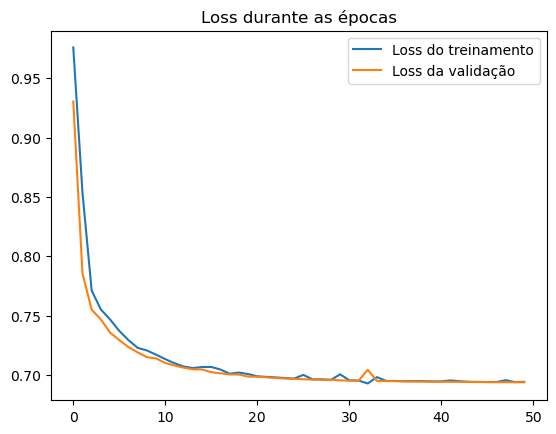

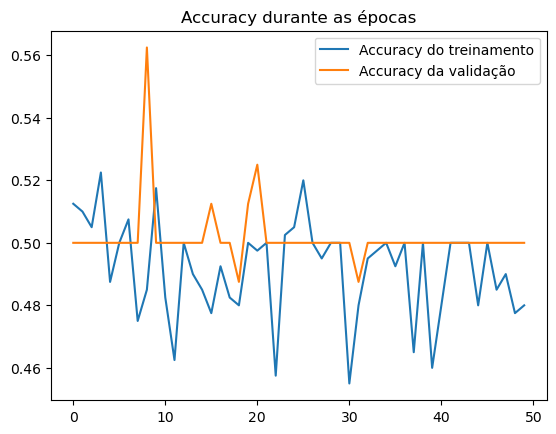

Validação do modelo de Lordose concluída!


In [60]:
lordosis_val_loss, lordosis_val_accuracy = lordosis_model.evaluate(lordosis_val_data)
print(f"Acurácia do modelo de Lordose: {lordosis_val_accuracy * 100:.2f}%")
print(f"Loss do modelo de Lordose: {lordosis_val_loss * 100:.2f}%")

plt.plot(lordosis_history.history['loss'], label='Loss do treinamento')
plt.plot(lordosis_history.history['val_loss'], label='Loss da validação')
plt.legend()
plt.title('Loss durante as épocas')
plt.show()

plt.plot(lordosis_history.history['accuracy'], label='Accuracy do treinamento')
plt.plot(lordosis_history.history['val_accuracy'], label='Accuracy da validação')
plt.legend()
plt.title('Accuracy durante as épocas')
plt.show()

print('Validação do modelo de Lordose concluída!')

###### Após isso, faremos o mesmo para o modelo de Cifose

13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4829 - loss: 0.6937
Acurácia do modelo de Cifose: 50.00%
Loss do modelo de Cifose: 69.37%


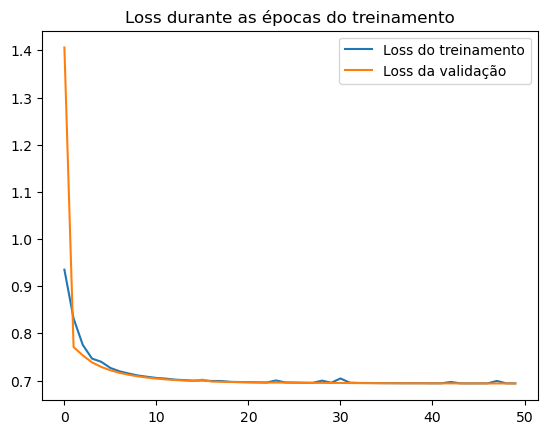

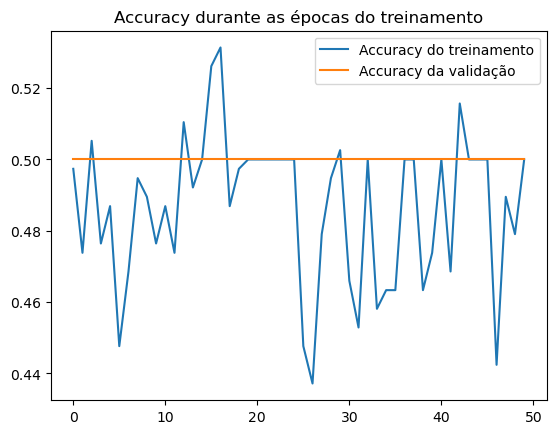

Validação do modelo de Cifose concluída!


In [59]:
kyphosis_val_loss, kyphosis_val_accuracy = kyphosis_model.evaluate(kyphosis_val_data)
print(f"Acurácia do modelo de Cifose: {kyphosis_val_accuracy * 100:.2f}%")
print(f"Loss do modelo de Cifose: {kyphosis_val_loss * 100:.2f}%")

plt.plot(kyphosis_history.history['loss'], label='Loss do treinamento')
plt.plot(kyphosis_history.history['val_loss'], label='Loss da validação')
plt.legend()
plt.title('Loss durante as épocas do treinamento')
plt.show()

plt.plot(kyphosis_history.history['accuracy'], label='Accuracy do treinamento')
plt.plot(kyphosis_history.history['val_accuracy'], label='Accuracy da validação')
plt.legend()
plt.title('Accuracy durante as épocas do treinamento')
plt.show()

print('Validação do modelo de Cifose concluída!')

###### Por último, faremos o mesmo para o modelo Generalista

/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7721 - loss: 0.6927
Acurácia do modelo Generalista: 78.11%
Loss do modelo Generalista: 69.45%


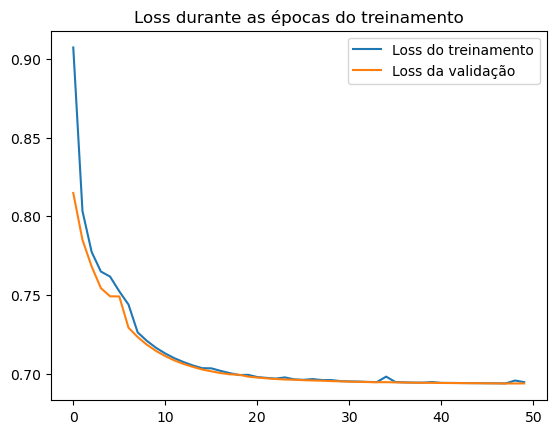

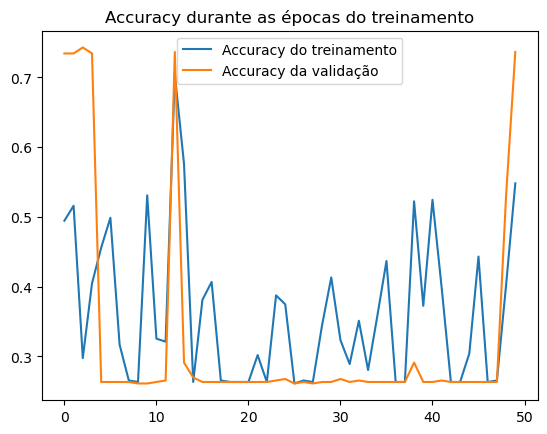

Validação do modelo de Generalista concluída!


In [58]:
generalist_val_loss, generalist_val_accuracy = generalist_model.evaluate(generalist_val_generator)
print(f"Acurácia do modelo Generalista: {generalist_val_accuracy * 100:.2f}%")
print(f"Loss do modelo Generalista: {generalist_val_loss * 100:.2f}%")

plt.plot(generalist_history.history['loss'], label='Loss do treinamento')
plt.plot(generalist_history.history['val_loss'], label='Loss da validação')
plt.legend()
plt.title('Loss durante as épocas do treinamento')
plt.show()

plt.plot(generalist_history.history['accuracy'], label='Accuracy do treinamento')
plt.plot(generalist_history.history['val_accuracy'], label='Accuracy da validação')
plt.legend()
plt.title('Accuracy durante as épocas do treinamento')
plt.show()

print('Validação do modelo de Generalista concluída!')

# Teste geral dos modelos

Para realizar o teste geral, vamos avaliar cada imagem do dataset nos modelos e comparar os resultados obtidos com os resultados esperados.

###### Para iniciar, vamos definir a função `predict_image_generalist_model` para fazer a normalização da imagem e retornar as condições previstas pelo modelo Generalista

In [62]:
def predict_image_generalist_model(image_path):
    image = cv2.imread(image_path)
    image = normalize_image(image)
    image = cv2.resize(image, (image_height, image_width))

    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0) 

    predictions = generalist_model.predict(image)[0]

    predicted_conditions = {
        'kyphosis': predictions[0],
        'lordosis': predictions[1]
    }

    return predicted_conditions

print('Definição da função de predição do modelo Generalista concluída!')

Definição da função de predição do modelo Generalista concluída!


###### Em seguida vamos definir a função `predict_image_specialist_model` que irá receber como parametros a imagem e o modelo a ser usado na predição, para assim retornar a classificação dada por esse modelo, além de normalizar a imagem para sua predição

In [66]:
def predict_image_specialist_model(image_path, model):
    image = cv2.imread(image_path)
    image = normalize_image(image)
    image = cv2.resize(image, (image_height, image_width))

    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0) 

    predictions = model.predict(image)

    return predictions

print('Definição da função de predição dos modelos Cifose e Lordose concluída!')

Definição da função de predição dos modelos Cifose e Lordose concluída!


##### Então, faremos a predição para todo o DataSet utilizado em cada um dos modelos, para assim termos a média de erros e acertos e o percentual de proximidade do resultado e compararemos qual modelo foi mais eficaz

In [64]:
label_mapping = {
    'healthy': {'kyphosis': 0, 'lordosis': 0},
    'lordosis': {'kyphosis': 0, 'lordosis': 1},
    'kyphosis': {'kyphosis': 1, 'lordosis': 0},
    'kyphosis_and_lordosis': {'kyphosis': 1, 'lordosis': 1}
}

correct_predictions = 0
incorrect_predictions = 0
error_log = []
error_count_by_class = {label: 0 for label in label_mapping}

for label, expected_values in label_mapping.items():
    folder_path = os.path.join(balanced_dataset_generalist_model_dir, label)
    
    if not os.path.isdir(folder_path):
        continue
    
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        
        predictions = predict_image_generalist_model(image_path)
        
        threshold = 0.5
        predicted_values = {
            'kyphosis': 1 if predictions['kyphosis'] > threshold else 0,
            'lordosis': 1 if predictions['lordosis'] > threshold else 0
        }
        
        if predicted_values == expected_values:
            correct_predictions += 1
        else:
            incorrect_predictions += 1
            error_count_by_class[label] += 1
            difference = {
                'kyphosis': abs(predictions['kyphosis'] - expected_values['kyphosis']),
                'lordosis': abs(predictions['lordosis'] - expected_values['lordosis'])
            }
            error_log.append({
                'image': image_path,
                'expected': expected_values,
                'predicted': predicted_values,
                'difference': difference,
                'class': label
            })

print(f"Total de acertos do modelo Generalista: {correct_predictions}")
print(f"Total de erros do modelo Generalista: {incorrect_predictions}")

print("\nErros por classe no modelo Generalista:")
for label, count in error_count_by_class.items():
    print(f"{label}: {count} erros")

print("\nErros detalhado no modelo Generalista:")
for error in error_log:
    print(error)

print('Teste geral do modelo Generalista concluído!')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

###### Agora faremos o mesmo para o modelo de Cifose

In [68]:
label_mapping = {
    'healthy': [1, 0],
    'kyphosis': [0, 1]
}

correct_predictions = 0
incorrect_predictions = 0
error_log = []

error_count_by_class = {label: 0 for label in label_mapping}

for label, expected_values in label_mapping.items():
    folder_path = os.path.join(balanced_dataset_kyphosis_model_dir, label)
    
    if not os.path.isdir(folder_path):
        continue
    
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        
        predictions = predict_image_specialist_model(image_path, kyphosis_model)[0]
        
        threshold = 0.5
        predicted_values = [
            1 if predictions[0] > threshold else 0,
            1 if predictions[1] > threshold else 0
        ]
        
        if predicted_values == expected_values:
            correct_predictions += 1
        else:
            incorrect_predictions += 1
            error_count_by_class[label] += 1
            difference = [
                abs(predictions[0] - expected_values[0]),
                abs(predictions[1] - expected_values[1])
            ]
            error_log.append({
                'image': image_path,
                'expected': expected_values,
                'predicted': predicted_values,
                'difference': difference,
                'class': label
            })

print(f"Total de acertos do modelo de Cifose: {correct_predictions}")
print(f"Total de erros do modelo de Cifose: {incorrect_predictions}")

print("\nErros por classe do modelo de Cifose:")
for label, count in error_count_by_class.items():
    print(f"{label}: {count} erros")

print("\nErros detalhados do modelo de Cifose:")
for error in error_log:
    print(error)

print('Teste geral do modelo de Cifose concluído!')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

###### Para finalizar nosso teste geral, faremos o mesmo para o modelo de Lordose 

In [69]:
label_mapping = {
    'healthy': [1, 0],
    'lordosis': [0, 1]
}

correct_predictions = 0
incorrect_predictions = 0
error_log = []

error_count_by_class = {label: 0 for label in label_mapping}

for label, expected_values in label_mapping.items():
    folder_path = os.path.join(balanced_dataset_lordosis_model_dir, label)
    
    if not os.path.isdir(folder_path):
        continue
    
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        
        predictions = predict_image_specialist_model(image_path, lordosis_model)[0]
        
        threshold = 0.5
        predicted_values = [
            1 if predictions[0] > threshold else 0,
            1 if predictions[1] > threshold else 0
        ]
        
        if predicted_values == expected_values:
            correct_predictions += 1
        else:
            incorrect_predictions += 1
            error_count_by_class[label] += 1
            difference = [
                abs(predictions[0] - expected_values[0]),
                abs(predictions[1] - expected_values[1])
            ]
            error_log.append({
                'image': image_path,
                'expected': expected_values,
                'predicted': predicted_values,
                'difference': difference,
                'class': label
            })

print(f"Total de acertos do modelo de Lordose: {correct_predictions}")
print(f"Total de erros do modelo de Lordose: {incorrect_predictions}")

print("\nErros por classe do modelo de Lordose:")
for label, count in error_count_by_class.items():
    print(f"{label}: {count} erros")

print("\nErros detalhados do modelo de Lordose:")
for error in error_log:
    print(error)

print('Teste geral do modelo de Lordose concluído!')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 